In [6]:
from astropy.io import fits
import numpy as np
import os.path
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import matplotlib.gridspec as gridspec
import aplpy
import pandas as pd
%matplotlib inline
from photutils import CircularAperture
from photutils import SkyCircularAperture
from photutils import aperture_photometry

In [3]:
def get_flux(wave, flux, fnfilter, filter_wave_factor=1.): 
    filt = pd.read_csv(fnfilter, delim_whitespace=True, names=['w','t'])
    filt['w'] *= filter_wave_factor
    filt_interp = np.interp(wave, filt['w'], filt['t']) 
    numerator = np.trapz(flux*filt_interp, x=wave)
    denominator = np.trapz(filt_interp, x=wave)

    return numerator/denominator

In [ ]:
#calculate IGM absorption: import LAFcoeff.txt & DLAcoeff.txt to get all coefficients
#lambda_alpha=1216, lambda_beta=1026
#if lambda_beta(1+z_em) < lambda_obs < lambda_alpha(1+z_em):
    #tau_eff = 0.0036*(lambda_obs/lambda_alpha)**3.46
#if lambda_gamma(1+z_em) < lambda_obs < lambda_beta(1+z_em):
    #tau_eff = 1.7e-03*(lambda_obs/lambda_alpha)**3.46 etc... needs to be summed

[900, 50000, 575676.07583122561, 12316838400.0]

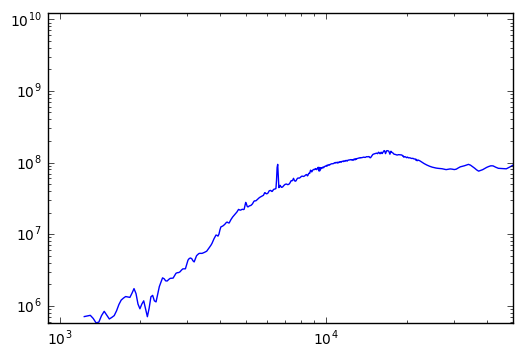

In [121]:
#swire templates testing
path = '/Users/justin/Documents/Master_Thesis/softwares/eazy/templates/swire_library/Sey2_template_norm.sed'
test = pd.read_csv(path, delim_whitespace=True, header=None, names=['w', 'f'])
test['f'] *= test['w']*test['w']
f= plt.figure()
ax=f.add_subplot(111)
ax.plot(test['w'], test['f'])
plt.yscale('log')
plt.xscale('log')
ymin, ymax= min(test['f']),max(test['f'])
plt.axis([900,50000,ymin,ymax])

In [7]:
filters = ['/Users/justin/Documents/Master_Thesis/data/surveys/goods/filter_curves/HST-ACS_HRC.F435W_b_eazy.dat',
           '/Users/justin/Documents/Master_Thesis/data/surveys/goods/filter_curves/HST-ACS_HRC.F606W_v_eazy.dat',
           '/Users/justin/Documents/Master_Thesis/data/surveys/goods/filter_curves/HST-ACS_HRC.F775W_i_eazy.dat',
           '/Users/justin/Documents/Master_Thesis/data/surveys/goods/filter_curves/HST-ACS_HRC.F850LP_z_eazy.dat',
           '/Users/justin/Documents/Master_Thesis/data/surveys/candels/filter_curves/f105w.IR_eazy.tab',
           '/Users/justin/Documents/Master_Thesis/data/surveys/candels/filter_curves/f125w.IR_eazy.tab',
           '/Users/justin/Documents/Master_Thesis/data/surveys/candels/filter_curves/f160w.IR_eazy.tab',
           '/Users/justin/Documents/Master_Thesis/data/surveys/hugs/filter_curves/hawki_Knew_eazy.dat',
           '/Users/justin/Documents/Master_Thesis/data/surveys/spitzer/filter_curves/spitzer36_eazy.tab',
           '/Users/justin/Documents/Master_Thesis/data/surveys/spitzer/filter_curves/spitzer45_eazy.tab']
filter_names = ['B', 'V', 'i', 'z', 'Y', 'J', 'H', 'Ks', '3.6mu', '4.5mu']
flux_cat = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
qsolist=['QSO1','QSO2','Torus','Sey2']
gallist=['S0','Sb','Sdm','Ell2','M82']
for qson in [1,2,3,4]:
    for galn in [1,2,3,4,5]:
        path = '/Users/justin/Documents/Master_Thesis/softwares/eazy/templates/swire_library/' + qsolist[qson-1] + '_template_norm.sed'
        qso = pd.read_csv(path, delim_whitespace=True, header=None, names=['w', 'f'])
        path = '/Users/justin/Documents/Master_Thesis/softwares/eazy/templates/swire_library/' + gallist[galn-1] + '_template_norm.sed'
        gal = pd.read_csv(path, delim_whitespace=True, header=None, names=['w', 'f'])
        for z in [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]:
            for agnfrac in [0.05,0.1,0.2,0.5,0.8,0.9,0.95]:
                for hflux in [0.2,0.5,1.]: #in muJy

                    Lqso = 0.
                    Lgal = 0.
                    w_L = np.zeros(4895)
                    for i in range(len(w_L)):
                        w_L[i]= 1050. + (i*10)
                    qso_interp = np.interp(w_L, qso['w'], qso['f'])
                    gal_interp = np.interp(w_L, gal['w'], gal['f'])
                    Lqso = np.trapz(qso_interp, x = w_L)
                    Lgal = np.trapz(gal_interp, x = w_L)
                    qso_z = qso['w'] * (1.+z)
                    gal_z = gal['w'] * (1.+z)
                    comb = np.zeros(len(gal))
                    qso_interp2 = np.interp(gal_z, qso_z, qso['f'])
                    comb = (1-agnfrac)*gal['f'] + (Lgal/Lqso*agnfrac*qso_interp2)
                    comb = comb*gal_z*gal_z
                    comb_flux = [0,0,0,0,0,0,0,0,0,0]
                    comb_fluxerr = [0,0,0,0,0,0,0,0,0,0]
                    rescaling = get_flux(gal_z, comb, filters[6], filter_wave_factor=1.) / hflux
                    for i in range(len(comb_flux)):
                        comb_flux[i] = get_flux(gal_z, comb, filters[i], filter_wave_factor=1.) / rescaling
                        if i < 8:
                            comb_fluxerr[i] = 0.1*comb_flux[i] + 0.015
                        else:
                            comb_fluxerr[i] = 0.25*comb_flux[i] + 0.015
                        if ((z>3) & (i<1)) | ((z>6) & (i<2)) | ((z>7) & (i<3)) | ((z>9) & (i<4)):
                            comb_flux[i] = 0.
                            comb_fluxerr[i] = 0.08
                        if (comb_flux[i] > 0.08):
                            pass
                        else:
                            comb_flux[i] = 0.
                            comb_fluxerr[i] = 0.08

                    id_ = z + 10000*agnfrac + 100000*hflux +1000000*qson + 10000000*galn

                    flux_cat[0].append(id_)
                    flux_cat[1].append(comb_flux[0])
                    flux_cat[2].append(comb_fluxerr[0])
                    flux_cat[3].append(comb_flux[1])
                    flux_cat[4].append(comb_fluxerr[1])
                    flux_cat[5].append(comb_flux[2])
                    flux_cat[6].append(comb_fluxerr[2])
                    flux_cat[7].append(comb_flux[3])
                    flux_cat[8].append(comb_fluxerr[3])
                    flux_cat[9].append(comb_flux[4])
                    flux_cat[10].append(comb_fluxerr[4])
                    flux_cat[11].append(comb_flux[5])
                    flux_cat[12].append(comb_fluxerr[5])
                    flux_cat[13].append(comb_flux[6])
                    flux_cat[14].append(comb_fluxerr[6])
                    flux_cat[15].append(comb_flux[7])
                    flux_cat[16].append(comb_fluxerr[7])
                    flux_cat[17].append(comb_flux[8])
                    flux_cat[18].append(comb_fluxerr[8])
                    flux_cat[19].append(comb_flux[9])
                    flux_cat[20].append(comb_fluxerr[9])

ar = np.array(flux_cat)
at = np.transpose(ar)
df = pd.DataFrame(data=at, index=None, columns=['id','F233','E233','F236','E236','F238','E238','F240','E240','F202','E202','F203','E203','F205','E205','F269','E269','F18','E18','F19','E19'])
df['id'] = df['id'].astype('int64')
path = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/fm_cat.cat'
df.to_csv(path_or_buf=path, sep=' ', index=False)
path = "sed -i '' '/id/s/^/# /g' ../softwares/eazy/inputs/fm_cat.cat"
os.system(path)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


0

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


TypeError: First argument must be a path or file object reading bytes

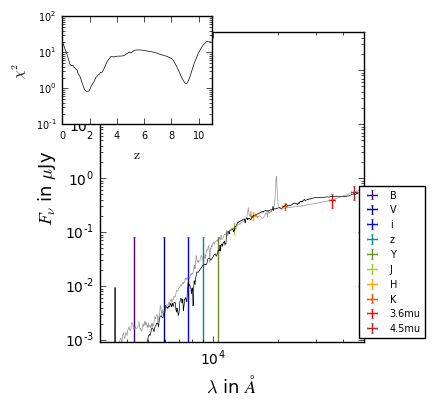

In [9]:
error_lw = 1.
error_w = 0.03
qsolist=['QSO1','QSO2','Torus','Sey2']
gallist=['S0','Sb','Sdm','Ell2','M82']
for qson in [1,2,3,4]:
    for galn in [1,2,3,4,5]: 
        path = '/Users/justin/Documents/Master_Thesis/softwares/eazy/templates/swire_library/' + qsolist[qson-1] + '_template_norm.sed'
        qso = pd.read_csv(path, delim_whitespace=True, header=None, names=['w', 'f'])
        path = '/Users/justin/Documents/Master_Thesis/softwares/eazy/templates/swire_library/' + gallist[galn-1] + '_template_norm.sed'
        gal = pd.read_csv(path, delim_whitespace=True, header=None, names=['w', 'f'])
        for z in [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]:
            for agnfrac in [0.05,0.1,0.2,0.5,0.8,0.9,0.95]:
                for hflux in [0.2,0.5,1.]: #in muJy
                    i = int(z + 10000*agnfrac + 100000*hflux + 1000000*qson + 10000000*galn)
                    path_sed = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT/photz_' + str(i) + '.temp_sed'
                    path_flx = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT/photz_' + str(i) + '.obs_sed'
                    path_chi = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT/photz_' + str(i) + '.pz'
                    cat_sed = pd.read_csv(path_sed, delim_whitespace=True, header=None, names=['Wavelength', 'Flux'], skiprows=[0,1])
                    cat_flx = pd.read_csv(path_flx, delim_whitespace=True, header=None, names=['Wavelength', 'FluxCat', 'FluxErrCat', 'FluxErrTot', 'FluxTemp'], skiprows=1)
                    cat_chi = pd.read_csv(path_chi, delim_whitespace=True, header=None, names=['z', 'Chi^2'], skiprows=1)

                    Lqso = 0.
                    Lgal = 0.
                    w_L = np.zeros(4895)
                    for n in range(len(w_L)):
                        w_L[n]= 1050. + (n*10)
                    qso_interp = np.interp(w_L, qso['w'], qso['f'])
                    gal_interp = np.interp(w_L, gal['w'], gal['f'])
                    Lqso = np.trapz(qso_interp, x = w_L)
                    Lgal = np.trapz(gal_interp, x = w_L)
                    qso_z = qso['w'] * (1.+z)
                    gal_z = gal['w'] * (1.+z)
                    comb = np.zeros(len(gal))
                    qso_interp2 = np.interp(gal_z, qso_z, qso['f'])
                    comb = (1-agnfrac)*gal['f'] + (Lgal/Lqso*agnfrac*qso_interp2)
                    comb = comb*gal_z*gal_z
                    rescaling = get_flux(gal_z, comb, filters[6], filter_wave_factor=1.) / hflux
                    comb = comb / rescaling

                    jy_to_mujy = 1.
                    f = plt.figure()
                    ax = f.add_subplot(111)
                    ax.plot(cat_sed['Wavelength'], cat_sed['Flux']*jy_to_mujy, marker='', lw=0.5, ls='-', color='black')
                    ax.plot(gal_z, comb*jy_to_mujy, marker='', lw=0.5, ls='-', color='dimgray', alpha=0.7)
                    plt.axis([3e3, 5e4, 9e-4, 5e+2])
                    ax.set_aspect(0.25)
                    for j in range(len(cat_flx)):
                        if cat_flx['Wavelength'][j] == 4328.683:
                            h1 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='indigo', label='B')
                        if (cat_flx['Wavelength'][j] > 5959.323) & (cat_flx['Wavelength'][j] < 5959.325):
                            h2 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='darkblue', label='V')
                        if (cat_flx['Wavelength'][j] > 7704.696) & (cat_flx['Wavelength'][j] < 7704.698):
                            h3 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='blue', label='i')
                        if cat_flx['Wavelength'][j] == 9.048604e+03:
                            h4 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='darkcyan', label='z')
                        if cat_flx['Wavelength'][j] == 1.057723e+04:
                            h5 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='olivedrab', label='Y')
                        if cat_flx['Wavelength'][j] == 1.250085e+04:
                            h6 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='yellowgreen', label='J')
                        if cat_flx['Wavelength'][j] == 1.541899e+04:
                            h7 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='orange', label='H')
                        if cat_flx['Wavelength'][j] == 2.154491e+04:
                            h8 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='orangered', label='K')
                        if cat_flx['Wavelength'][j] == 3.563426e+04:
                            h9 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='red', label='3.6mu')
                        if cat_flx['Wavelength'][j] == 4.511019e+04:
                            h10 = plt.errorbar(cat_flx['Wavelength'][j], cat_flx['FluxCat'][j]*jy_to_mujy, xerr=cat_flx['Wavelength'][j]*error_w, yerr=cat_flx['FluxErrTot'][j]*jy_to_mujy, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='firebrick', label='4.5mu')
                    plt.legend(handles=[h1,h2,h3,h4,h5,h6,h7,h8,h9,h10],numpoints=1,fontsize=7,loc='lower right', bbox_to_anchor=(1.25, 0.))
                    plt.xscale('log')
                    plt.yscale('log')
                    plt.xlabel('$\lambda$ in $\AA$', size=13)
                    plt.ylabel('$F_{\\nu}$ in $\mu$Jy', size=13)
                    a = plt.axes([0.23, .67, .25, .27])
                    #labels=['B','V','i','z','Y','J','H','K','3.6mu','4.5mu']
                    a.plot(cat_chi['z'], cat_chi['Chi^2'], marker='', lw=0.5, ls='-', color='black')
                    plt.yscale('log')
                    x1,x2,y1,y2 = plt.axis()
                    plt.axis((0,11,y1,y2))
                    plt.xlabel('$\mathrm{z}$', size=10)
                    plt.ylabel('$\mathrm{\chi^2}$', size=10)
                    for label in (a.get_xticklabels() + a.get_yticklabels()):
                        label.set_fontsize(7)
                    path = '/Users/justin/Documents/Master_Thesis/presentation/plots/eazy/fm/photz_' + str(i) + '.pdf'
                    plt.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
                    plt.clf()

In [10]:
path = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT/photz.zout'
cat = pd.read_csv(path, delim_whitespace=True, header=None, names=['id', 'x1', 'z', 'z_m1', 'chi', 'l1', 'u1', 'l2', 'u2', 'l3', 'u3', 'n', 'q_z', 'z_peak', 'peak_prob', 'z_mc'], skiprows=[0,1])
for qson in [1,2,3,4]:
    for galn in [1,2,3,4,5]:
        f1 = plt.figure()
        ax1 = f1.add_subplot(111)
        for z in [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]:
            for agnfrac in [0.05,0.1,0.2,0.5,0.8,0.9,0.95]:
                for hflux in [0.2,0.5,1.]:
                    ID = int(z + 10000*agnfrac + 100000*hflux + 1000000*qson + 10000000*galn)
                    for i in range(len(cat)):
                        if cat['id'][i]==ID:
                            if (cat['u1'][i] > z) & (cat['l1'][i] < z):
                                col='black'
                                mark='o'
                            elif (cat['u2'][i] > z) & (cat['l2'][i] < z):
                                col='darkgray'
                                mark='o'
                            elif (cat['u3'][i] > z) & (cat['l3'][i] < z):
                                col='white'
                                mark='o'
                            else:
                                col='black'
                                mark='x'
                            if hflux == 0.2:
                                ax1.plot(z, np.log10(agnfrac/(1-agnfrac)), marker=mark, color=col)
                                plt.ylabel('$log(L_{bol,BH}/L^{*}_{bol})$')
                                plt.xlabel('z')
        ax1.set_aspect(11./3.)
        ax1.axis([0, 11, -1.5, 1.5])
        path = '/Users/justin/Documents/Master_Thesis/presentation/plots/forward_modeling/fm' + str(qson) + str(galn) + '.pdf'
        f1.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
        plt.clf()


In [54]:
path = '/Users/justin/Documents/Master_Thesis/softwares/eazy/inputs/OUTPUT/photz.zout'
cat = pd.read_csv(path, delim_whitespace=True, header=None, names=['id', 'x1', 'z', 'z_m1', 'chi', 'l1', 'u1', 'l2', 'u2', 'l3', 'u3', 'n', 'q_z', 'z_peak', 'peak_prob', 'z_mc'], skiprows=[0,1])
deltaz=np.zeros(10)
deltaz2=np.zeros(10)
deltaz_5=np.zeros(10)
deltaz2_5=np.zeros(10)
deltaz_50=np.zeros(10)
deltaz2_50=np.zeros(10)
deltaz_95=np.zeros(10)
deltaz2_95=np.zeros(10)
nz=420.
nz2=60.
z = [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]
z_5 = np.zeros(10)
z_50 = np.zeros(10)
z_95 = np.zeros(10)
for i in range(len(z)):
    z_5[i] = z[i] - 0.05
    z_50[i] = z[i] + 0.05
    z_95[i] = z[i] + 0.1
agnfrac = [0.05,0.1,0.2,0.5,0.8,0.9,0.95]
for i in range(len(cat)):
    for j in range(len(z)):
        if (int(cat['id'][i]) % 10 == j) & (j==0):
            deltaz[9] -= (z[9] - cat['z'][i])/nz
            deltaz2[9] += ((z[9] - cat['z'][i])**2.)
            if np.floor(cat['id'][i]/100.) %100 == 5:
                deltaz_5[9] -= (z[9] - cat['z'][i])/nz2
                deltaz2_5[9] += ((z[9] - cat['z'][i])**2.)
            if np.floor(cat['id'][i]/100.) %100 == 50:
                deltaz_50[9] -= (z[9] - cat['z'][i])/nz2
                deltaz2_50[9] += ((z[9] - cat['z'][i])**2.)
            if np.floor(cat['id'][i]/100.) %100 == 95:
                deltaz_95[9] -= (z[9] - cat['z'][i])/nz2
                deltaz2_95[9] += ((z[9] - cat['z'][i])**2.)
        if (int(cat['id'][i]) % 10 == j) & (j>0):
            deltaz[j-1] -= (z[j-1] - cat['z'][i])/nz
            deltaz2[j-1] += ((z[j-1] - cat['z'][i])**2.)
            if np.floor(cat['id'][i]/100.) %100 == 5:
                deltaz_5[j-1] -= (z[j-1] - cat['z'][i])/nz2
                deltaz2_5[j-1] += ((z[j-1] - cat['z'][i])**2.)
            if np.floor(cat['id'][i]/100.) %100 == 50:
                deltaz_50[j-1] -= (z[j-1] - cat['z'][i])/nz2
                deltaz2_50[j-1] += ((z[j-1] - cat['z'][i])**2.)
            if np.floor(cat['id'][i]/100.) %100 == 95:
                deltaz_95[j-1] -= (z[j-1] - cat['z'][i])/nz2
                deltaz2_95[j-1] += ((z[j-1] - cat['z'][i])**2.)
for i in range(len(deltaz2)):
    deltaz2[i] = (deltaz2[i]**0.5)/nz
    deltaz2_5[i] = (deltaz2_5[i]**0.5)/nz2
    deltaz2_50[i] = (deltaz2_50[i]**0.5)/nz2
    deltaz2_95[i] = (deltaz2_95[i]**0.5)/nz2
f1 = plt.figure()
ax1 = f1.add_subplot(111)
h1=plt.errorbar(z, deltaz + z, yerr=deltaz2, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='black',label='Total')
h5=plt.errorbar(z_5, deltaz_5 + z, yerr=deltaz2_5, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='red',label='$(L_{bol,BH}/L^{*}_{bol})=0.05$')
h50=plt.errorbar(z_50, deltaz_50 + z, yerr=deltaz2_50, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='blue',label='$(L_{bol,BH}/L^{*}_{bol})=0.5$')
h95=plt.errorbar(z_95, deltaz_95 + z, yerr=deltaz2_95, ls='', capsize=0.5, capthick=0.5, elinewidth=error_lw, color='green',label='$(L_{bol,BH}/L^{*}_{bol})=0.95$')
plt.plot([0,11],[0,11],ls='--',lw=0.5,color='black')
A = np.array([z, np.ones(10)])
w = np.linalg.lstsq(A.T,deltaz + z)[0]
w_5 = np.linalg.lstsq(A.T,deltaz_5 + z)[0]
w_50 = np.linalg.lstsq(A.T,deltaz_50 + z)[0]
w_95 = np.linalg.lstsq(A.T,deltaz_95 + z)[0]
plt.plot([0,11], [w[1], 11*w[0]+w[1]],'black', ls='-', lw=0.3)
plt.plot([0,11], [w_5[1], 11*w_5[0]+w_5[1]],'red', ls='-', lw=0.3)
plt.plot([0,11], [w_50[1], 11*w_50[0]+w_50[1]],'blue', ls='-', lw=0.3)
plt.plot([0,11], [w_95[1], 11*w_95[0]+w_95[1]],'green', ls='-', lw=0.3)
ax1.set_aspect(1.)
ax1.axis([0, 11, 0, 11])
plt.xlabel('z')
plt.ylabel('EAZY photometric z')
plt.legend(handles=[h1,h5,h50,h95],numpoints=1,fontsize=7,loc='lower right', bbox_to_anchor=(1.25, 0.))
path = '/Users/justin/Documents/Master_Thesis/presentation/plots/forward_modeling/deltaz_z.pdf'
f1.savefig(path, format='pdf', dpi=1000,bbox_inches='tight')
plt.clf()

